In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

baseline_path = Path("../reports/metrics_noq/metrics_summary.tsv")
tuned_path    = Path("../reports/hparam_tuning_noq/tuned_models_summary.tsv")

baseline = pd.read_csv(baseline_path, sep="\t")
tuned    = pd.read_csv(tuned_path,    sep="\t")

# 1) Clean up old model_base if it exists
for df in (baseline, tuned):
    if "model_base" in df.columns:
        del df["model_base"]

# 2) Create normalized model key
tuned["model_base"]    = tuned["model"].str.replace("_tuned$", "", regex=True)
baseline["model_base"] = baseline["model"]

# 3) Drop original 'model' columns to avoid suffix conflict
for df in (baseline, tuned):
    if "model" in df.columns:
        del df["model"]

# 4) Merge on model_base
merged = baseline.merge(
    tuned,
    on="model_base",
    suffixes=("_base", "_tuned"),
)

# 5) Nice display name
merged["model_name"] = merged["model_base"]

# 6) Sort by tuned F1
merged = merged.sort_values("test_f1_tuned", ascending=False).reset_index(drop=True)

merged[[
    "model_name",
    "test_f1_base", "test_roc_auc_base",
    "test_f1_tuned", "test_roc_auc_tuned"
]]

,model_name,test_f1_base,test_roc_auc_base,test_f1_tuned,test_roc_auc_tuned
0,catboost,0.766937,0.839231,0.768624,0.843612
1,gradient_boosting,0.766322,0.840075,0.767268,0.843432
2,lightgbm,0.763626,0.838415,0.765701,0.841586
3,xgboost,0.764706,0.838843,0.764525,0.839134
4,random_forest,0.754946,0.834358,0.763223,0.842031
5,bagging_trees,0.759538,0.837333,0.762757,0.842014
6,extra_trees,0.753201,0.823516,0.759977,0.837355
7,mlp,0.748055,0.819283,0.748727,0.821486
8,logreg_l2,0.744278,0.820653,0.743057,0.818275
9,linear_svm_calibrated,0.744355,0.820463,0.742718,0.817765


BEFORE AND AFTER HYPERTUNING

/var/folders/sj/r5b1vnb91cjffx5_zt6rs8v80000gn/T/ipykernel_75919/2969250602.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")


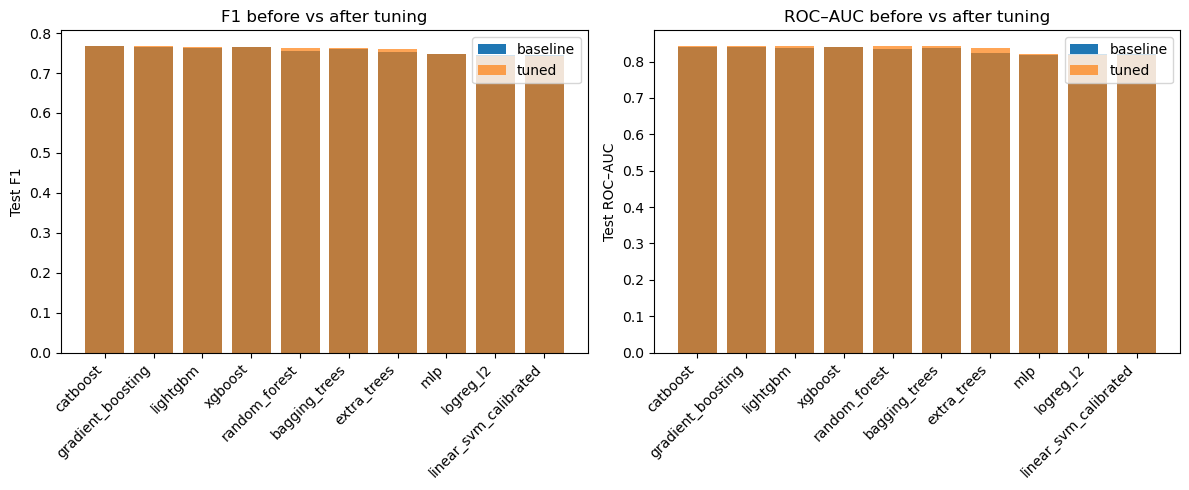

In [22]:
import matplotlib.pyplot as plt

# Use the merged you already computed
plot_df = merged.copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# 1) F1
axes[0].set_xticks(range(len(plot_df["model_name"])))
axes[0].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")


axes[0].bar(plot_df["model_name"], plot_df["test_f1_base"], label="baseline")
axes[0].bar(plot_df["model_name"], plot_df["test_f1_tuned"],
            alpha=0.7, label="tuned")
axes[0].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
axes[0].set_ylabel("Test F1")
axes[0].set_title("F1 before vs after tuning")
axes[0].legend()

# 2) ROC–AUC
axes[1].bar(plot_df["model_name"], plot_df["test_roc_auc_base"], label="baseline")
axes[1].bar(plot_df["model_name"], plot_df["test_roc_auc_tuned"],
            alpha=0.7, label="tuned")
axes[1].set_xticklabels(plot_df["model_name"], rotation=45, ha="right")
axes[1].set_ylabel("Test ROC–AUC")
axes[1].set_title("ROC–AUC before vs after tuning")
axes[1].legend()

plt.tight_layout()
plt.show()

In [25]:
from joblib import load
from mitochime.hyperparam_search_top import load_dataset

X_test, y_test, feature_names = load_dataset("../data/processed/test_noq.tsv")

models = {
    # best overall boosted tree
    "catboost": load("../models_noq_tuned/catboost_tuned.joblib"),

    # strong boosted tree from scikit-learn (easier to explain)
    "gradient_boosting": load("../models_noq_tuned/gradient_boosting_tuned.joblib"),

    # non-boosted tree ensemble baseline
    "random_forest": load("../models_noq_tuned/random_forest_tuned.joblib"),

    # simple linear baseline for contrast (optional but nice for thesis narrative)
    "logreg_l2": load("../models_noq_tuned/logreg_l2_tuned.joblib"),
}

CONFUSION MATRIX + CLASSIFICATION REPORT


=== catboost ===
              precision    recall  f1-score   support

       clean     0.7342    0.9462    0.8268      3997
    chimeric     0.9245    0.6577    0.7686      4000

    accuracy                         0.8019      7997
   macro avg     0.8293    0.8020    0.7977      7997
weighted avg     0.8294    0.8019    0.7977      7997



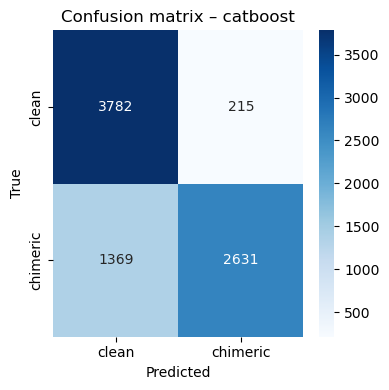


=== gradient_boosting ===
              precision    recall  f1-score   support

       clean     0.7327    0.9492    0.8270      3997
    chimeric     0.9280    0.6540    0.7673      4000

    accuracy                         0.8016      7997
   macro avg     0.8304    0.8016    0.7971      7997
weighted avg     0.8304    0.8016    0.7971      7997



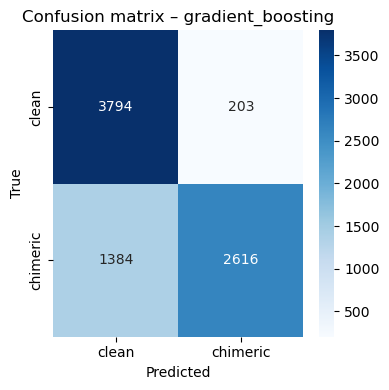


=== random_forest ===
              precision    recall  f1-score   support

       clean     0.7310    0.9390    0.8220      3997
    chimeric     0.9148    0.6548    0.7632      4000

    accuracy                         0.7968      7997
   macro avg     0.8229    0.7969    0.7926      7997
weighted avg     0.8229    0.7968    0.7926      7997



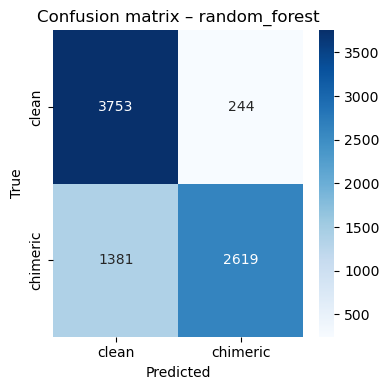


=== logreg_l2 ===
              precision    recall  f1-score   support

       clean     0.7130    0.9647    0.8200      3997
    chimeric     0.9455    0.6120    0.7431      4000

    accuracy                         0.7883      7997
   macro avg     0.8293    0.7884    0.7815      7997
weighted avg     0.8293    0.7883    0.7815      7997



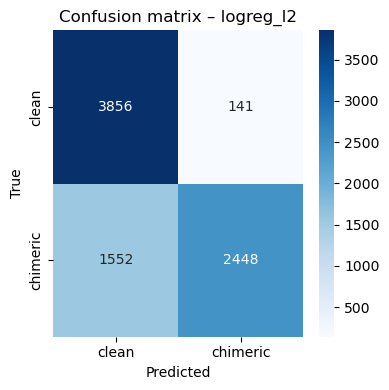

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # if you don't want seaborn, we can do pure matplotlib

for name, model in models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    print(classification_report(
        y_test, y_pred,
        target_names=["clean", "chimeric"],
        digits=4,
        zero_division=0,
    ))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["clean", "chimeric"],
                yticklabels=["clean", "chimeric"])
    plt.title(f"Confusion matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

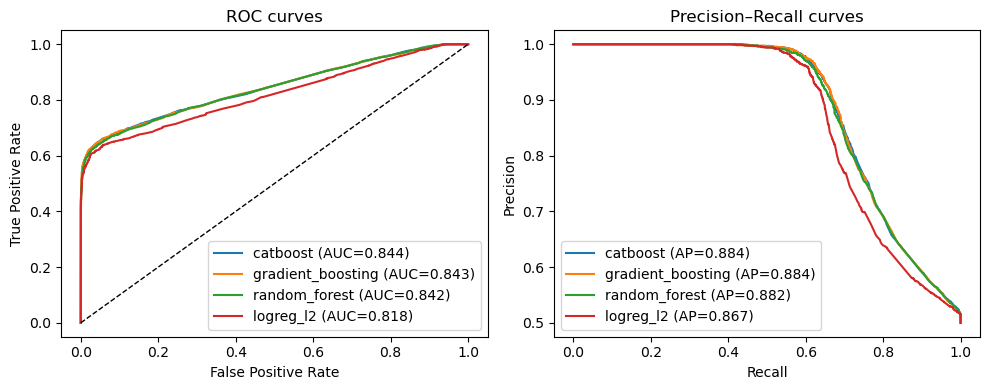

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

plt.figure(figsize=(10,4))

# ROC
plt.subplot(1,2,1)
for name, model in models.items():
    # scores: probas if available, else decision_function
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()

# PR
plt.subplot(1,2,2)
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
    else:
        continue

    prec, rec, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend()

plt.tight_layout()
plt.show()


=== Permutation importance (catboost) ===
                 feature  importance_mean  importance_std
20    kmer_js_divergence         0.062482        0.003460
17   total_clipped_bases         0.052942        0.002152
19      kmer_cosine_diff         0.052920        0.001864
16        softclip_right         0.044855        0.002611
15         softclip_left         0.044242        0.002227
1                   mapq         0.005123        0.001021
3               sa_count         0.002608        0.001338
21  microhomology_length         0.001768        0.000861
22      microhomology_gc         0.001425        0.000816
12          sa_mean_mapq         0.000413        0.000765

=== Permutation importance (gradient_boosting) ===
                 feature  importance_mean  importance_std
17   total_clipped_bases         0.124546        0.003038
20    kmer_js_divergence         0.057085        0.003228
19      kmer_cosine_diff         0.047884        0.002113
1                   mapq         0.

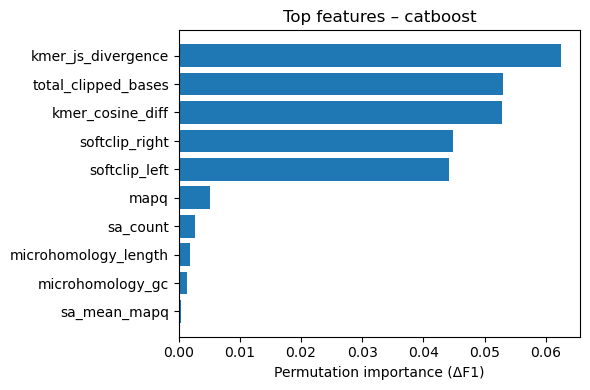

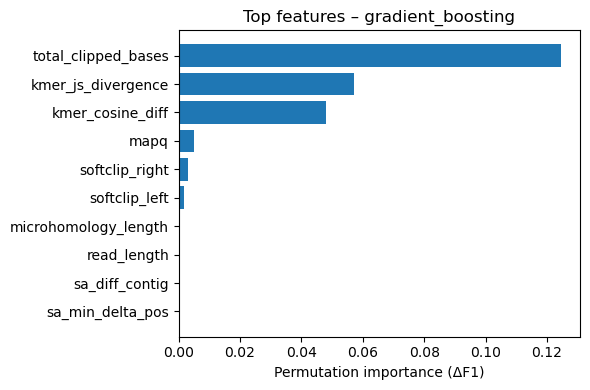

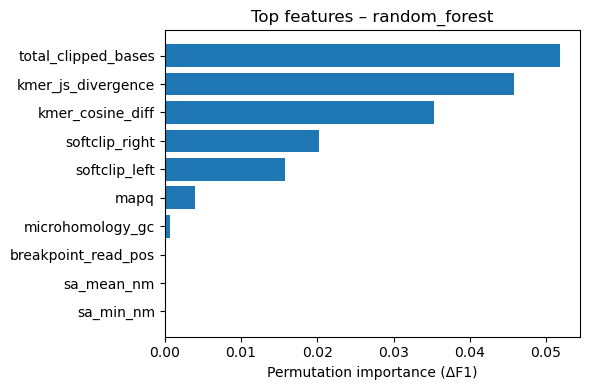

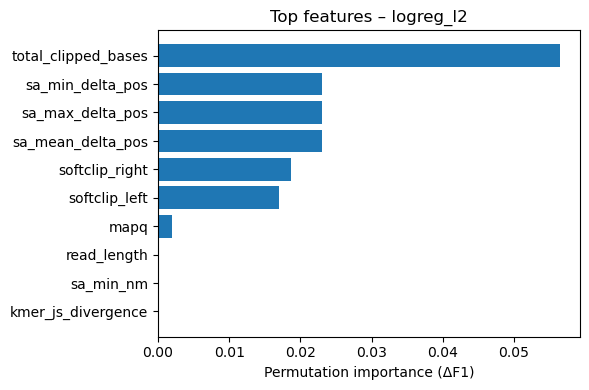

In [43]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

def perm_importance(model, X, y, feature_names, scoring="f1", n_repeats=10):
    result = permutation_importance(
        model, X, y,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1,
        scoring=scoring,
    )
    df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }).sort_values("importance_mean", ascending=False)
    return df

# 1. Compute perm importance for EACH model explicitly
imp_results = {}
for name, model in models.items():   # models = {"catboost": ..., "gradient_boosting": ..., ...}
    print(f"\n=== Permutation importance ({name}) ===")
    df_imp = perm_importance(model, X_test, y_test, feature_names, scoring="f1")
    imp_results[name] = df_imp
    print(df_imp.head(10))          # <- this table now matches the correct model

# 2. Plot top 10 features for each model
for name in ["catboost", "gradient_boosting", "random_forest", "logreg_l2"]:
    df_imp = imp_results[name]
    top = df_imp.nlargest(10, "importance_mean")  # top 10, highest first

    plt.figure(figsize=(6, 4))
    plt.barh(top["feature"], top["importance_mean"])
    plt.xlabel("Permutation importance (ΔF1)")
    plt.title(f"Top features – {name}")
    plt.gca().invert_yaxis()  # so most important is at the top
    plt.tight_layout()
    plt.show()

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Define which feature belongs to which family ---

family_map = {
    "SA_structure": [
        "has_sa",
        "sa_count",
        "num_segments",
        "sa_diff_contig",
        "sa_min_delta_pos",
        "sa_max_delta_pos",
        "sa_mean_delta_pos",
        "sa_same_strand_count",
        "sa_opp_strand_count",
        "sa_max_mapq",
        "sa_mean_mapq",
        "sa_min_nm",
        "sa_mean_nm",
    ],
    "Clipping": [
        "softclip_left",
        "softclip_right",
        "total_clipped_bases",
        "breakpoint_read_pos",
    ],
    "Kmer_jump": [
        "kmer_cosine_diff",
        "kmer_js_divergence",
    ],
    "Micro_homology": [
        "microhomology_length",
        "microhomology_gc",
    ],
    # optional: alignment quality / misc features
    "Other": [
        "mapq",      # alignment quality
        # add any remaining numeric features that don't fit above
        # e.g. "ref_start_1based" if it is still in your noq feature set
    ],
}

In [45]:
def aggregate_family_importance(df_imp: pd.DataFrame, family_map: dict) -> pd.DataFrame:
    """
    df_imp: DataFrame with columns ["feature", "importance_mean", "importance_std"]
    returns: DataFrame with one row per family, summing importance_mean of its features.
    """
    rows = []
    for fam, feats in family_map.items():
        sub = df_imp[df_imp["feature"].isin(feats)]
        if sub.empty:
            continue
        rows.append({
            "family": fam,
            "importance_sum": sub["importance_mean"].sum(),
            "importance_mean": sub["importance_mean"].mean(),
            "n_features": len(sub),
        })
    fam_df = pd.DataFrame(rows).sort_values("importance_sum", ascending=False)
    return fam_df

In [46]:
family_results = {}

for model_name, df_imp in imp_results.items():
    fam_df = aggregate_family_importance(df_imp, family_map)
    family_results[model_name] = fam_df
    print(f"\n=== Aggregated feature families – {model_name} ===")
    display(fam_df)


=== Aggregated feature families – catboost ===


,family,importance_sum,importance_mean,n_features
1,Clipping,0.142039,0.035510,4
2,Kmer_jump,0.115402,0.057701,2
4,Other,0.005123,0.005123,1
0,SA_structure,0.003356,0.000258,13
3,Micro_homology,0.003193,0.001597,2



=== Aggregated feature families – gradient_boosting ===


,family,importance_sum,importance_mean,n_features
1,Clipping,0.129395,0.032349,4
2,Kmer_jump,0.104969,0.052485,2
4,Other,0.005019,0.005019,1
3,Micro_homology,0.000062,0.000031,2
0,SA_structure,-0.003137,-0.000241,13



=== Aggregated feature families – random_forest ===


,family,importance_sum,importance_mean,n_features
1,Clipping,0.087863,0.021966,4
2,Kmer_jump,0.080981,0.040491,2
4,Other,0.003988,0.003988,1
3,Micro_homology,0.000592,0.000296,2
0,SA_structure,-0.004481,-0.000345,13



=== Aggregated feature families – logreg_l2 ===


,family,importance_sum,importance_mean,n_features
1,Clipping,0.092051,0.023013,4
0,SA_structure,0.069162,0.005320,13
4,Other,0.001918,0.001918,1
2,Kmer_jump,0.000000,0.000000,2
3,Micro_homology,-0.000011,-0.000006,2


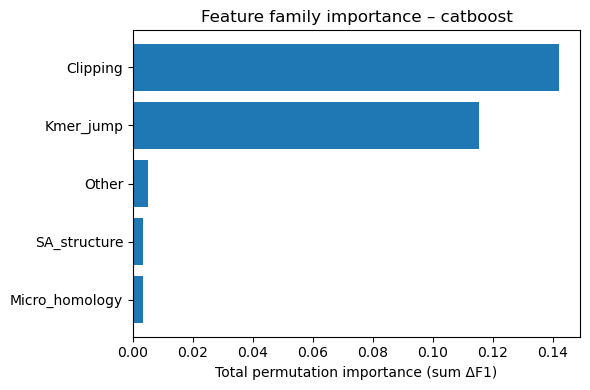

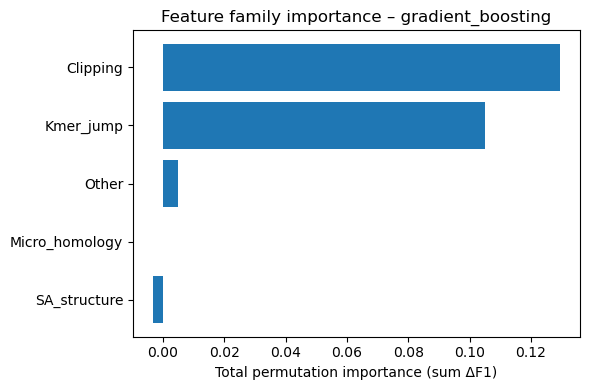

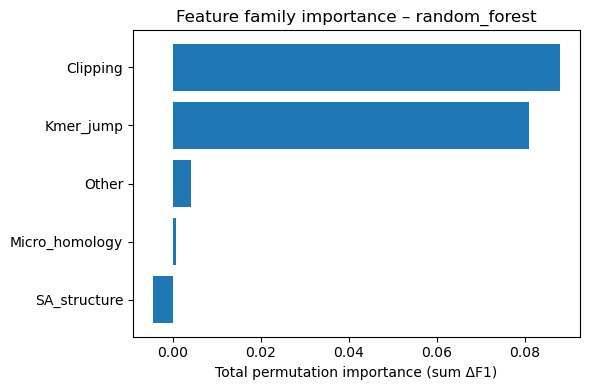

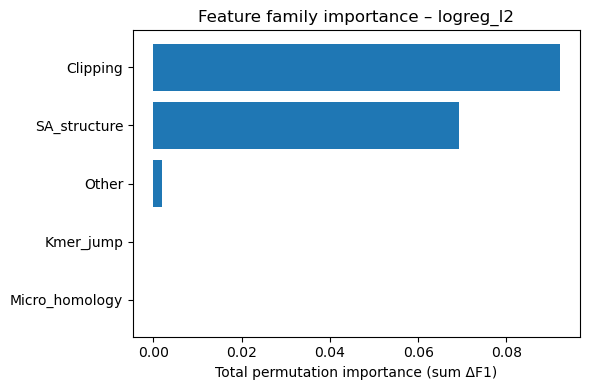

In [47]:
for model_name, fam_df in family_results.items():
    # sort so the smallest bar is at bottom
    fam_sorted = fam_df.sort_values("importance_sum", ascending=True)

    plt.figure(figsize=(6, 4))
    plt.barh(fam_sorted["family"], fam_sorted["importance_sum"])
    plt.xlabel("Total permutation importance (sum ΔF1)")
    plt.title(f"Feature family importance – {model_name}")
    plt.tight_layout()
    plt.show()